Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [77]:
import numpy as np
import matplotlib.pyplot as plt

In [78]:
NUM_KNAPSACKS = 3
NUM_ITEMS = 10
NUM_DIMENSIONS = 2

In [79]:
VALUES = np.random.randint(0, 100, size=NUM_ITEMS)
WEIGHTS = np.random.randint(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = np.random.randint(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [80]:
import numpy as np
from typing import Tuple

class KnapsackSolver:
    """
    Multidimensional 0-1 Knapsack solver Hill Climbing approach.
    """
    
    def __init__(self, num_knapsacks: int, num_items: int, num_dimensions: int, values: np.ndarray, weights: np.ndarray, constraints: np.ndarray):
        
        # Problem parameters
        self.num_knapsacks = num_knapsacks
        self.num_items = num_items
        self.num_dimensions = num_dimensions
        self.values = values          
        self.weights = weights        
        self.constraints = constraints 
        self.rng = np.random.default_rng()

        """ Review: to increase the efficency of the code it could be usefull to use a different rappresentation
        of the solution as an array of length NUM_iTEMS with solution[i] = k where k is the knapsack that have 
        the object or k=-1 if the object is not assigned to a knapsack """
        self.possible_assignments = list(range(-1,self.num_knapsacks))
    
    def _get_initial_solution(self) -> np.ndarray:
        return np.full(shape=self.num_items, fill_value=-1, dtype=int)
    
        
    # --- Evaluation Methods ---

    def get_value(self, solution: np.ndarray) -> float:
        """Calculates the un-penalized total value of items included in the knapsacks."""
        """ selected_items_mask = np.any(solution, axis=0)
        return np.sum(self.values[selected_items_mask]) """

        """  Review: with the new structure we can get the total value directly from it """
        total_value=0
        for i in range(self.num_items):
            if solution[i] != -1: # check if the object is contained in a knapsack
                total_value += self.values[i]
        return total_value

    def validSolution(self, solution: np.ndarray) -> bool:
        """ Checks if the solution is valid based on uniqueness and capacity constraints.
        # 1. Uniqueness check (1 item only in 1 knapsack)
        if not np.all(solution.sum(axis=0) <= 1):
            return False
            
        # 2. Capacity check (sum of weights vs. constraints)
        for k in range(self.num_knapsacks):
            total_weight = self.weights[solution[k]].sum(axis=0)
            if np.any(total_weight > self.constraints[k]):
                return False
        return True """

        """ Review: No more need to check the uniqueness, just save all the knapsack that exceed the CONSTRAINTS """
        try:
            usage = np.zeros((self.num_knapsacks, self.num_dimensions))

            for i in range(self.num_items):
                k = solution[i]
                
                if k != -1:
                    usage[k] += self.weights[i]
            if np.any(usage > self.constraints):
                return False
            
            return True
            
        except IndexError:
            # if the solution contain an invalid index
            return False 

    def fitness(self, solution: np.ndarray) -> float:
        """Returns the total value if valid, otherwise a large negative penalty."""
        if not self.validSolution(solution):
            return -1e9
        return self.get_value(solution)
        
    
    def make_valid(self, temp_solution: np.ndarray) -> np.ndarray:
        """Make the solution valid by fixing uniqueness and capacity violations."""
        # Fix uniqueness violations first
        duplicates = np.where(temp_solution.sum(axis=0) > 1)[0]
        if len(duplicates) > 0:
            for item in duplicates:
                knapsack_indices = np.where(temp_solution[:, item])[0]
                for k in knapsack_indices[1:]:
                    temp_solution[k, item] = False
        
        # Address capacity violations by randomly removing items
        while not self.validSolution(temp_solution):
            knapsack = self.rng.integers(0, self.num_knapsacks)
            items_in_knapsack = np.where(temp_solution[knapsack])[0]
            
            if len(items_in_knapsack) == 0:
                continue
                
            item_to_remove = self.rng.choice(items_in_knapsack)
            temp_solution[knapsack, item_to_remove] = False
            
        return temp_solution

    # --- Tweak function ---


    # Review: this tweak does not explore the search space properly because it just add item, when all the items are assigned the tweak will be useless even if the solution does not reach an optimal
    def tweak(self, solution: np.ndarray) -> np.ndarray:
        """Generates a neighbor by randomly attempting to ADD a single item to an empty slot.
        new_solution = solution.copy()
        
        # Loop until an empty slot (j, i) is found
        while True:
            i = self.rng.integers(0, self.num_items)
            j = self.rng.integers(0, self.num_knapsacks)
            
            if not solution[j, i]:
                break
                
        # Attempt to ADD the item to the empty slot
        new_solution[j, i] = True
        
        return new_solution """
    
    # Review: an example tweak to understand better what a tweak needs to do
        """
        Apply a single random mutation to the solution. It takes a random object and add/remove it to a knapsack
        """
        neighbor = solution.copy()
        
        # 1. choose a random item
        item_to_tweak = self.rng.integers(0, self.num_items)
        current_assignment = solution[item_to_tweak]
        
        # 2. give it a new random assignement
        other_assignments = [a for a in self.possible_assignments if a != current_assignment]
        new_assignment = self.rng.choice(other_assignments)
        
        neighbor[item_to_tweak] = new_assignment
        return neighbor

    # --- Main Solver Method ---

    def solve_knapsack(self, initial_solution: np.ndarray = None, max_iter: int = 1000, verbose: bool = False) -> Tuple[np.ndarray, float]:
        
        if initial_solution is None:
            """ solution = np.zeros((self.num_knapsacks, self.num_items), dtype=bool) """
            # Review: new solution structure
            solution = self._get_initial_solution()
        else:
            solution = initial_solution.copy()

        # Review: no more needed
        """ # Start with a feasible solution
        solution = self.make_valid(solution) """

        # Keep global best solution
        best_solution = solution.copy()
        best_fitness = self.fitness(best_solution)

        # Current solution that updates over time
        cur_solution = solution.copy()    
        cur_fitness = best_fitness

        # Review: Add fitness history to plot the result of the search
        fitness_history = [cur_fitness]
        
        if verbose:
            print(f"Initial Feasible Fitness: {best_fitness:.2f}")

        for iteration in range(max_iter):
            # Tweak the current solution
            new_solution = self.tweak(cur_solution)

            # Evaluate fitness (penalty is applied if infeasible)
            new_fitness = self.fitness(new_solution)
            
            # 1. Update Global Best Solution
            if new_fitness > best_fitness:
                best_solution = new_solution.copy()
                best_fitness = new_fitness

            # 2. Acceptance Criteria (Pure Greedy Hill Climbing): 
            # Only accept the move if it is STRICTLY BETTER than the current solution.

            # Review: Pure Greedy Hill climbing can be ok but I think that adding an acceptance for
            # solutions with equal fitness can help your algorithm to explore the plateau and escape from local optima. 
            if new_fitness >= cur_fitness:
                cur_solution = new_solution
                cur_fitness = new_fitness
        
            fitness_history.append(cur_fitness)

        return best_solution, best_fitness, fitness_history

In [81]:
def plot_fitness_history(history: list, title: str = "Fitness History"):
    plt.figure(figsize=(12, 6))
    plt.plot(history)
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Fitness (Total Value)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

## TEST PROBLEMS

In [82]:
# Problem 1:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 20
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [83]:
solver = KnapsackSolver(NUM_KNAPSACKS, NUM_ITEMS, NUM_DIMENSIONS, VALUES, WEIGHTS, CONSTRAINTS)

# Run the solver (max_iter set to 5000 for a quick but decent result)
solution, value, fitness_history = solver.solve_knapsack(max_iter=5000)
# Print the output
print(f"Problem: {NUM_KNAPSACKS} Knapsacks, {NUM_ITEMS} Items")
print(f"Best Total Value Found: {value:.2f}")

Problem: 3 Knapsacks, 20 Items
Best Total Value Found: 1065.00


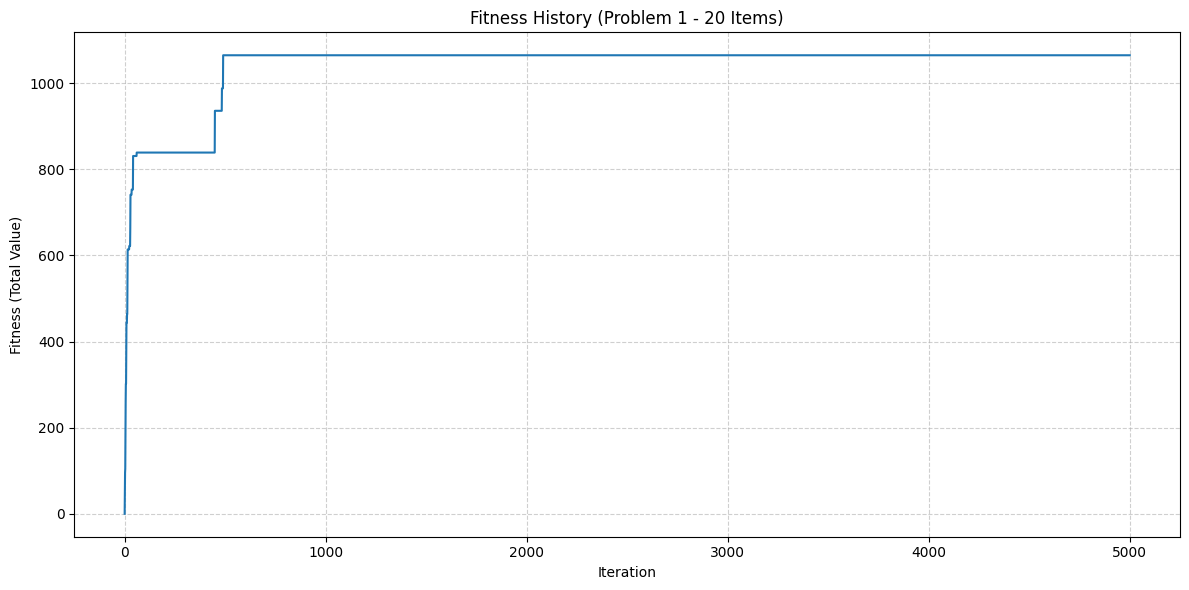

In [84]:
plot_fitness_history(fitness_history, title=f"Fitness History (Problem 1 - {NUM_ITEMS} Items)")

In [85]:
# Problem 2:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 10
NUM_ITEMS = 100
NUM_DIMENSIONS = 10
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 2, 1000 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [86]:
solver = KnapsackSolver(NUM_KNAPSACKS, NUM_ITEMS, NUM_DIMENSIONS, VALUES, WEIGHTS, CONSTRAINTS)

# Run the solver (max_iter set to 5000 for a quick but decent result)
solution, value, fitness_history = solver.solve_knapsack(max_iter=5000)

# Print the output
print(f"Problem: {NUM_KNAPSACKS} Knapsacks, {NUM_ITEMS} Items")
print(f"Best Total Value Found: {value:.2f}")

Problem: 10 Knapsacks, 100 Items
Best Total Value Found: 41168.00


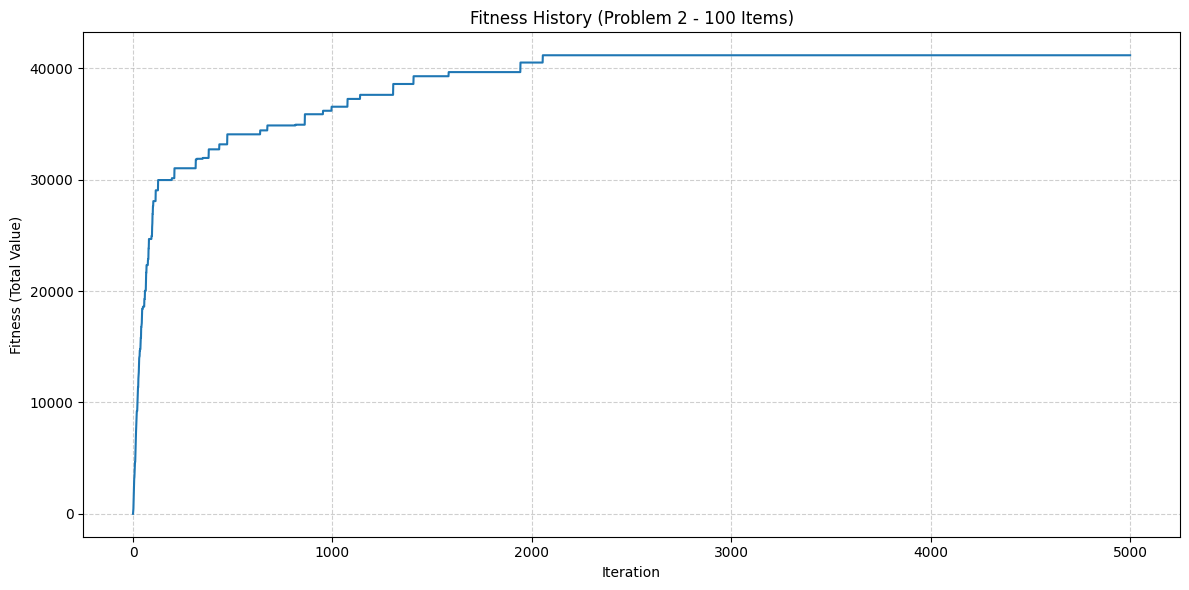

In [87]:
plot_fitness_history(fitness_history, title=f"Fitness History (Problem 2 - {NUM_ITEMS} Items)")

In [88]:
# Problem 3:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 100
NUM_ITEMS = 5000
NUM_DIMENSIONS = 100
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 10, 1000 * 2 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [89]:
solver = KnapsackSolver(NUM_KNAPSACKS, NUM_ITEMS, NUM_DIMENSIONS, VALUES, WEIGHTS, CONSTRAINTS)

# Run the solver (max_iter set to 5000 for a quick but decent result)
solution, value, fitness_history = solver.solve_knapsack(max_iter=5000)

# Print the output
print(f"Problem: {NUM_KNAPSACKS} Knapsacks, {NUM_ITEMS} Items")
print(f"Best Total Value Found: {value:.2f}")

Problem: 100 Knapsacks, 5000 Items
Best Total Value Found: 1098955.00


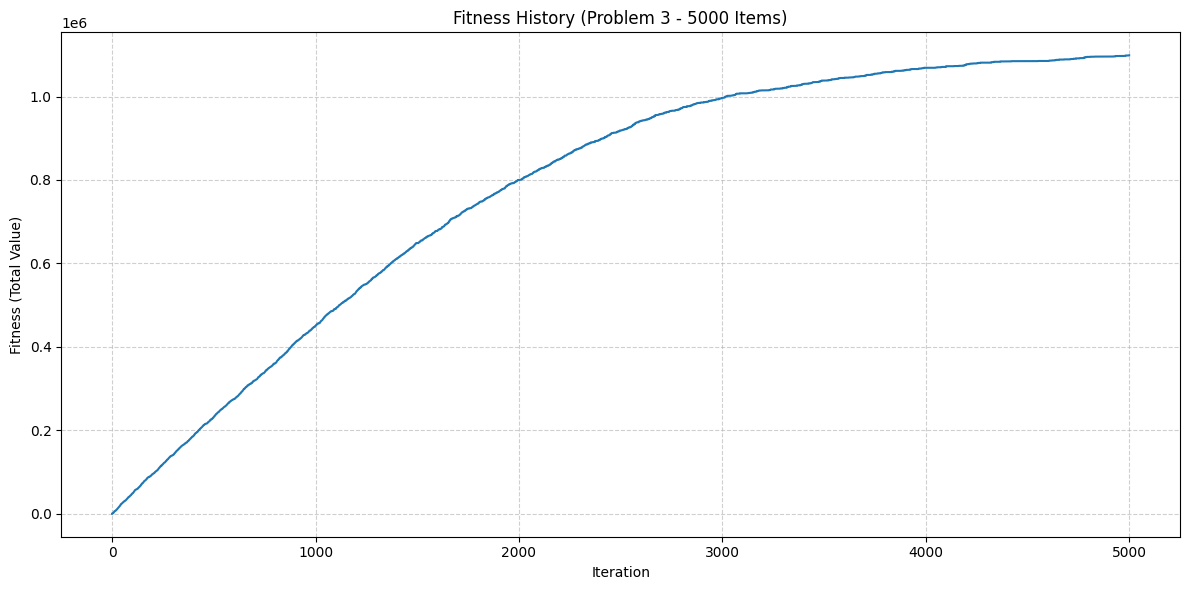

In [90]:
plot_fitness_history(fitness_history, title=f"Fitness History (Problem 3 - {NUM_ITEMS} Items)")